**Reference:** [Integrated Gradients](https://arxiv.org/abs/1703.01365)


# Imports


In [1]:
import hashlib
import os
import re
import jax
import GPUtil
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import jax.numpy as jnp
import seaborn as sns

from copy import deepcopy
from pathlib import Path
from scipy.stats import spearmanr, pearsonr
from colabfold.batch import get_queries, run, set_model_type
from colabfold.colabfold import plot_protein
from colabfold.download import download_alphafold_params
from colabfold.plot import plot_msa_v2
from colabfold.utils import setup_logging
from tqdm.auto import tqdm

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUtil.getFirstAvailable(order='memory', attempts=5, interval=30)[0]}"

# Configuration


- Taken directly from the [Colabfold Notebook](https://github.com/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)


## Input Settings


- B1 domain of Protein G according to [UniProt](https://www.rcsb.org/sequence/3GB1#A):
  > TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
- Protein G according to [UniProt](https://www.uniprot.org/uniprotkb/P06654/entry):
  > VDSPIEDTPIIRNGGELTNLLGNSETTLALRNEESATADLTAAAVADTVAAAAAENAGAAAWEAAAAADALAKAKADALKEFNKYGVSDYYKNLINNAKTVEGIKDLQAQVVESAKKARISEATDGLSDFLKSQTPAEDTVKSIELAEAKVLANRELDKYGVSDYHKNLINNAKTVEGVKELIDEILAALPKTDTYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTEKPEVIDASELTPAVTTYKLVINGKTLKGETTTKAVDAETAEKAFKQYANDNGVDGVWTYDDATKTFTVTEMVTEVPGDAPTEPEKPEASIPLVPLTPATPIAKDDAKKDDTKKEDAKKPEAKKDDAKKAETLPTT
- Tendamistat according to [UniProt](https://www.rcsb.org/sequence/1OK0):
  > DTTVSEPAPSCVTLYQSWRYSQADNGCAQTVTVKVVYEDDTEGLCYAVAPGQITTVGDGYIGSHGHARYLARCL
- Sso10a from Sulfolobus solfataricus according to [UniProt](https://www.rcsb.org/sequence/1R7J)
  > MAKKKSKLEIIQAILEACKSGSPKTRIMYGANLSYALTGRYIKMLMDLEIIRQEGKQYMLTKKGEELLEDIRKFNEMRKNMDQLKEKINSVLSIRQ
- Hylin-a1 according to [UniProt](https://www.uniprot.org/uniprotkb/P85982/entry)
  > IFGAILPLALGALKNLIK
- Conantokin-T (Con-T) according to [UniProt](https://www.uniprot.org/uniprotkb/P17684/entry)
  > GEEEYQKMLENLREAEVKKNA
- Humanin (Humanin mitochondrial) (HNM) according to [UniProt](https://www.uniprot.org/uniprotkb/Q8IVG9/entry)
  > MAPRGFSCLLLLTSEIDLPVKRRA
- CMTI-I(TrypsinInhibitor1) according to [UniProt](https://www.uniprot.org/uniprotkb/P01074/entry)
  > RVCPRILMECKKDSDCLAECVCLEHGYCG
- Alpha-conotoxin RgIA according to [UniProt](https://www.uniprot.org/uniprotkb/P0C1D0/entry)
  > GCCSDPRCRYRCR
- PP according to [UniProt](https://www.uniprot.org/uniprotkb/P68249/entry)
  > GPSQPTYPGDDAPVEDLIRFYNDLQQYLNVVTRHRY
- EAFP2 according to [UniProt](https://www.uniprot.org/uniprotkb/P83597/entry)
  > QTCASRCPRPCNAGLCCSIYGYCGSGAAYCGAGNCRCQCRG
- Ferredoxin according to [UniProt](https://www.uniprot.org/uniprotkb/P00198/entry)
  > MAYVINEACISCGACEPECPVNAISSGDDRYVIDADTCIDCGACAGVCPVDAPVQA


In [3]:
# Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
query_sequence = "TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE"

protein_name = "B1"
# Name of the experiment
jobname = f"IG_{protein_name}"

# Specify how many of the top ranked structures to relax using amber
num_relax = 0  # possible values - [0, 1, 5]

# Whether to use pdb100 templates or not
use_templates = False

# whether to use amber relaxation or not
use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

In [4]:
def add_hash(x, y):
    return x + "_" + hashlib.sha1(y.encode()).hexdigest()[:5]


basejobname = "".join(jobname.split())
basejobname = re.sub(r"\W+", "", basejobname)
jobname = add_hash(basejobname, query_sequence)

In [5]:
# check if directory with jobname exists
def check(folder):
    if os.path.exists(folder):
        return False
    else:
        return True


if not check(jobname):
    n = 0
    while not check(f"{jobname}_{n}"):
        n += 1
    jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
    text_file.write(f"id,sequence\n{jobname},{query_sequence}")

In [6]:
print("jobname", jobname)
print("sequence", query_sequence)
print("length", len(query_sequence.replace(":", "")))

jobname IG_B1_4c347
sequence TYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE
length 55


In [7]:
# MSA options - [single sequence, pairing mode]
# possible values - ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence"]
msa_mode = "mmseqs2_uniref_env"

# "unpaired_paired" = pair sequences from same species + unpaired MSA,
# "unpaired" = seperate MSA for each chain,
# "paired" - only use paired sequences.
# possible values - ["unpaired_paired","paired","unpaired"] {type:"string"}
pair_mode = "unpaired_paired"


# decide which a3m to use
if "mmseqs2" in msa_mode:
    a3m_file = os.path.join(jobname, f"{jobname}.a3m")
else:
    a3m_file = os.path.join(jobname, f"{jobname}.single_sequence.a3m")
    with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

## Advanced Settings


In [8]:
# possible values -
#     ["auto", "alphafold2_ptm", "alphafold2_multimer_v1",
#     "alphafold2_multimer_v2", "alphafold2_multimer_v3", "deepfold_v1"]
#
# If `auto` is selected, will use `alphafold2_ptm` for monomer prediction and
# `alphafold2_multimer_v3` for complex prediction.
# Any of the mode_types can be used (regardless if input is monomer or complex).
model_type = "auto"

# possible values - ["auto", "0", "1", "3", "6", "12", "24", "48"]
# If `auto` selected, will use `num_recycles=20` if
# `model_type=alphafold2_multimer_v3`, else `num_recycles=3` .
num_recycles = "3"

# possible values - ["auto", "0.0", "0.5", "1.0"]
# If `auto` is selected, will use `tol=0.5`
# if `model_type=alphafold2_multimer_v3` else `tol=0.0`.
recycle_early_stop_tolerance = "auto"

# possible values - [0, 200, 2000]
# Max amber relaxation iterations, `0` = unlimited (default, takes very long)
relax_max_iterations = 200

# possible values - ["greedy", "complete"]
# `greedy` = pair any taxonomically matching subsets,
# `complete` = all sequences have to match in one line.
pairing_strategy = "greedy"

In [9]:
# process config
num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = (
    None
    if recycle_early_stop_tolerance == "auto"
    else float(recycle_early_stop_tolerance)
)

## Sampling settings


In [10]:
# Decrease `max_msa` to increase uncertainity
# possible values - ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
max_msa = "auto"

# Increase number of seeds to sample predictions from uncertainty of the model
# possible values - [1,2,4,8,16]
num_seeds = 1

# Whether to enable or disable dropouts
use_dropout = False

In [11]:
# process config
if max_msa == "auto":
    max_msa = None

## Save settings


In [12]:
save_all = True
save_recycles = False

# Set dpi for image resolution
dpi = 200

## Initial Setup


In [13]:
result_dir = jobname
log_filename = os.path.join(jobname, "log.txt")
setup_logging(Path(log_filename))

In [14]:
queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

In [15]:
use_cluster_profile = not ("multimer" in model_type and max_msa is not None)

In [16]:
download_alphafold_params(model_type, Path("."))

In [17]:
def input_features_callback(input_features):
    plot_msa_v2(input_features)
    plt.show()
    plt.close()


def prediction_callback(
    protein_obj, length, prediction_result, input_features, mode
):
    model_name, relaxed = mode
    if not relaxed:
        fig = plot_protein(protein_obj, Ls=length, dpi=150)
        plt.show()
        plt.close()

# Alphafold2 IG on Input Sequence


## Integrated Gradients


### Obtain Internal Variables


INFO:2025-01-02 21:51:39,153:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-01-02 21:51:39,157:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


2025-01-02 21:51:39,153 Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-01-02 21:51:39,157 Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2025-01-02 21:51:40,833 Running on GPU
2025-01-02 21:51:41,127 Found 5 citations for tools or databases
2025-01-02 21:51:41,127 Query 1/1: IG_B1_4c347 (length 55)


COMPLETE: 100%|██████████| 150/150 [elapsed: 00:00 remaining: 00:00]


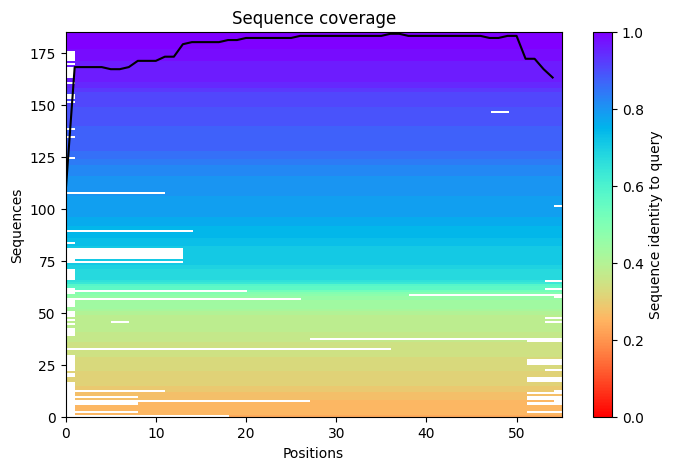

2025-01-02 21:51:42,304 Setting max_seq=185, max_extra_seq=1


I0000 00:00:1735854711.036076   32858 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


2025-01-02 21:52:21,806 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=94.3 pTM=0.743
2025-01-02 21:52:22,119 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=95.4 pTM=0.778 tol=0.148
2025-01-02 21:52:22,431 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=95.8 pTM=0.787 tol=0.0822
2025-01-02 21:52:22,747 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=96.2 pTM=0.791 tol=0.0459
2025-01-02 21:52:22,748 alphafold2_ptm_model_1_seed_000 took 31.5s (3 recycles)


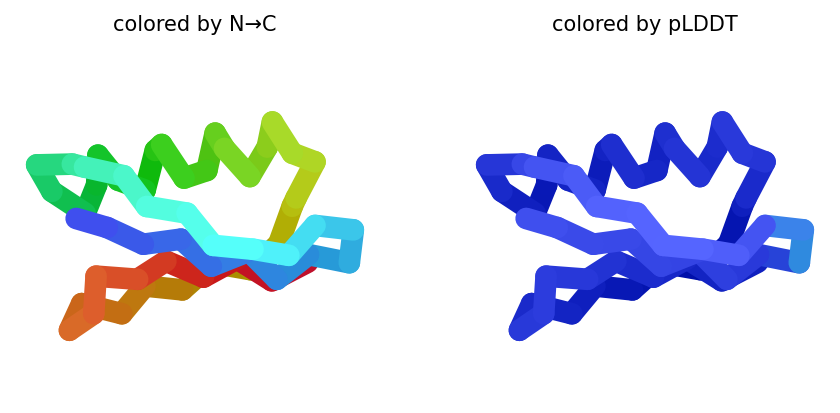

2025-01-02 21:52:23,152 alphafold2_ptm_model_2_seed_000 recycle=0 pLDDT=94.2 pTM=0.746
2025-01-02 21:52:23,464 alphafold2_ptm_model_2_seed_000 recycle=1 pLDDT=94.9 pTM=0.763 tol=0.0826
2025-01-02 21:52:23,774 alphafold2_ptm_model_2_seed_000 recycle=2 pLDDT=95.5 pTM=0.776 tol=0.0492
2025-01-02 21:52:24,090 alphafold2_ptm_model_2_seed_000 recycle=3 pLDDT=96.4 pTM=0.794 tol=0.038
2025-01-02 21:52:24,090 alphafold2_ptm_model_2_seed_000 took 1.2s (3 recycles)


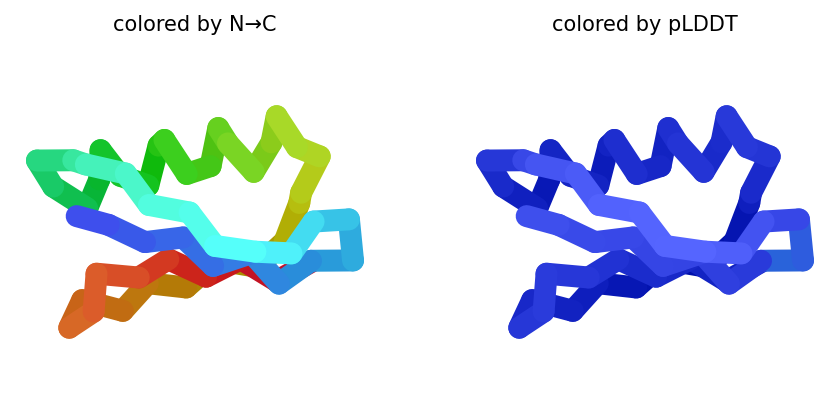

2025-01-02 21:52:24,489 alphafold2_ptm_model_3_seed_000 recycle=0 pLDDT=94.2 pTM=0.737
2025-01-02 21:52:24,799 alphafold2_ptm_model_3_seed_000 recycle=1 pLDDT=94.7 pTM=0.754 tol=0.101
2025-01-02 21:52:25,112 alphafold2_ptm_model_3_seed_000 recycle=2 pLDDT=94.4 pTM=0.748 tol=0.0537
2025-01-02 21:52:25,425 alphafold2_ptm_model_3_seed_000 recycle=3 pLDDT=94.8 pTM=0.754 tol=0.0295
2025-01-02 21:52:25,426 alphafold2_ptm_model_3_seed_000 took 1.2s (3 recycles)


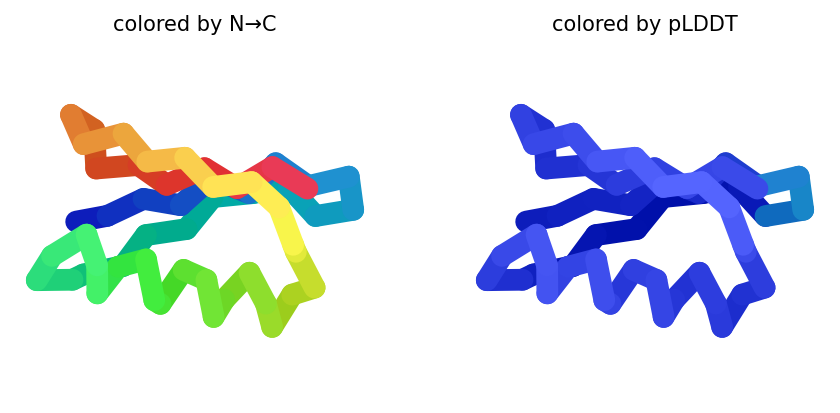

2025-01-02 21:52:25,822 alphafold2_ptm_model_4_seed_000 recycle=0 pLDDT=95.1 pTM=0.753
2025-01-02 21:52:26,133 alphafold2_ptm_model_4_seed_000 recycle=1 pLDDT=95.1 pTM=0.762 tol=0.153
2025-01-02 21:52:26,446 alphafold2_ptm_model_4_seed_000 recycle=2 pLDDT=95.3 pTM=0.767 tol=0.05
2025-01-02 21:52:26,759 alphafold2_ptm_model_4_seed_000 recycle=3 pLDDT=95.8 pTM=0.775 tol=0.0338
2025-01-02 21:52:26,760 alphafold2_ptm_model_4_seed_000 took 1.2s (3 recycles)


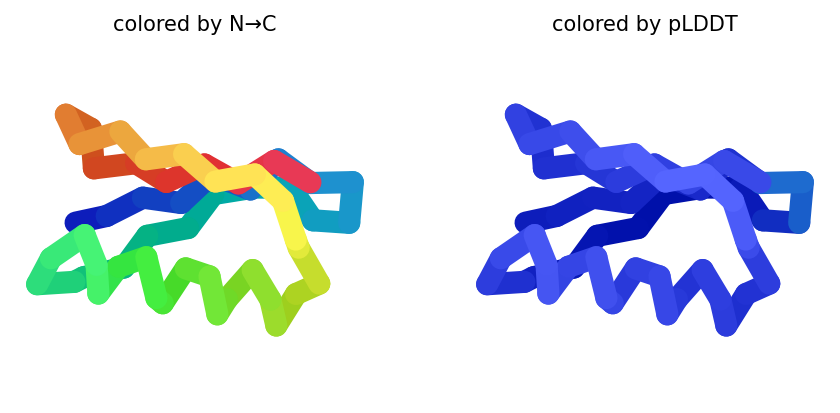

2025-01-02 21:52:27,157 alphafold2_ptm_model_5_seed_000 recycle=0 pLDDT=95.2 pTM=0.763
2025-01-02 21:52:27,469 alphafold2_ptm_model_5_seed_000 recycle=1 pLDDT=96.2 pTM=0.795 tol=0.11
2025-01-02 21:52:27,785 alphafold2_ptm_model_5_seed_000 recycle=2 pLDDT=96.6 pTM=0.801 tol=0.0819
2025-01-02 21:52:28,101 alphafold2_ptm_model_5_seed_000 recycle=3 pLDDT=97.1 pTM=0.81 tol=0.0515
2025-01-02 21:52:28,102 alphafold2_ptm_model_5_seed_000 took 1.3s (3 recycles)


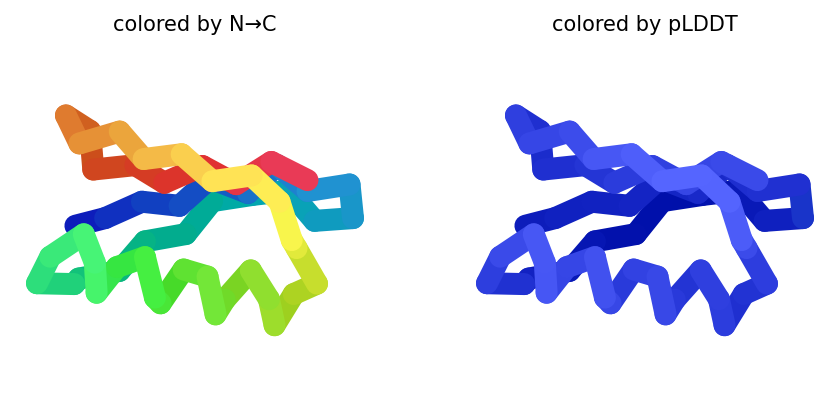

2025-01-02 21:52:28,186 reranking models by 'plddt' metric
2025-01-02 21:52:28,186 rank_001_alphafold2_ptm_model_5_seed_000 pLDDT=97.1 pTM=0.81
2025-01-02 21:52:28,187 rank_002_alphafold2_ptm_model_2_seed_000 pLDDT=96.4 pTM=0.794
2025-01-02 21:52:28,187 rank_003_alphafold2_ptm_model_1_seed_000 pLDDT=96.2 pTM=0.791
2025-01-02 21:52:28,187 rank_004_alphafold2_ptm_model_4_seed_000 pLDDT=95.8 pTM=0.775
2025-01-02 21:52:28,188 rank_005_alphafold2_ptm_model_3_seed_000 pLDDT=94.8 pTM=0.754
2025-01-02 21:52:29,172 Done


In [18]:
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=None,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    relax_max_iterations=relax_max_iterations,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1, 2, 3, 4, 5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
    user_agent="colabfold/google-colab-main",
    # use_bfloat16=False,
)

### Define Gradient Function in Jax


In [19]:
# List of tuples, each tuple with the following entries:
# 1. Model name
# 2. Model Instance
# 3. Model Parameters
model_runner_and_params = results["locals"]["model_runner_and_params"]

# Choose the first model for prototyping
model_name, model_runner, model_params = model_runner_and_params[0]
model_runner.params = model_params  # replace with correct parameters

# Get input features for the given protein sequence
feature_dict = results["locals"]["feature_dict"]
input_features = model_runner.process_features(feature_dict, random_seed=0)
r = input_features["aatype"].shape[0]
input_features["asym_id"] = np.tile(feature_dict["asym_id"], r).reshape(r, -1)
single_iter_input_features = jax.tree.map(lambda x: x[0:1], input_features)

In [20]:
# get shapes
aatype = input_features["aatype"]
num_iters = num_recycles + 1
num_ensemble = 1
L = aatype.shape[1]

# initialize


def zeros(shape): return np.zeros(shape, dtype=np.float16)


prev = {
    "prev_msa_first_row": zeros([L, 256]),
    "prev_pair": zeros([L, L, 128]),
    "prev_pos": zeros([L, 37, 3]),
}
key = jax.random.PRNGKey(0)

In [21]:
# Define a wrapping function to calculate the appropriate gradient
exec(
    rf"""
def f_wrap(model_params, key, tree, {", ".join(single_iter_input_features.keys())}, prev):
    args = [{", ".join(single_iter_input_features.keys())}]
    unflattened_tree = jax.tree.unflatten(tree, args)
    return model_runner.apply(model_params, key, {{**unflattened_tree, "prev": prev}})["ranking_confidence"]
    """
)

In [22]:
# print name of the input and it's corresponding index to use with jax grad
for idx, name in enumerate(single_iter_input_features.keys()):
    print((idx + 3, name))

(3, 'aatype')
(4, 'asym_id')
(5, 'atom14_atom_exists')
(6, 'atom37_atom_exists')
(7, 'bert_mask')
(8, 'extra_deletion_value')
(9, 'extra_has_deletion')
(10, 'extra_msa')
(11, 'extra_msa_mask')
(12, 'extra_msa_row_mask')
(13, 'is_distillation')
(14, 'msa_feat')
(15, 'msa_mask')
(16, 'msa_row_mask')
(17, 'random_crop_to_size_seed')
(18, 'residue_index')
(19, 'residx_atom14_to_atom37')
(20, 'residx_atom37_to_atom14')
(21, 'seq_length')
(22, 'seq_mask')
(23, 'target_feat')
(24, 'true_msa')


In [23]:
# create the gradient function for the first model
grad_model_runner = jax.grad(f_wrap, argnums=14, allow_int=True)

### IG Implementation


In [24]:
def IG(
    single_iter_input_features,
    single_iter_model,
    model_params,
    grad_model_runner,
    N,
    reference="zero",
):
    single_iter_model.config.model.num_recycle = 0
    ig_results, _ = single_iter_model.predict(
        single_iter_input_features, return_representations=True
    )
    if reference.lower() == "zero":
        baseline = jnp.zeros_like(single_iter_input_features["msa_feat"])
    else:
        raise NotImplementedError

    ig_output = jnp.zeros_like(single_iter_input_features["msa_feat"])
    ig_input_features = deepcopy(single_iter_input_features)
    for i in tqdm(range(N), total=N, desc="IG"):
        ig_input_features["msa_feat"] = baseline + (
            (single_iter_input_features["msa_feat"] - baseline) * i / N
        )
        _, tree = jax.tree.flatten(ig_input_features)
        gradients = grad_model_runner(
            model_params, key, tree, *[*ig_input_features.values(), prev]
        )
        ig_output += gradients
    ig_output = ig_output*(single_iter_input_features['msa_feat'] - baseline)
    return ig_results, np.squeeze(np.asanyarray(ig_output / N))

In [25]:
ig_results, ig_output = IG(
    single_iter_input_features,
    model_runner,
    model_params,
    grad_model_runner,
    20,
)

# first index corresponds to input
ig_output_input_seq = ig_output[0]

IG:   0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
ig_importances = np.linalg.norm(ig_output_input_seq, axis=-1)
ig_importances = ig_importances/np.linalg.norm(ig_importances)  # normalize

In [27]:
ig_importances.shape

(55,)

In [28]:
char2peptide = {
    'C': 'CYS',
    'D': 'ASP',
    'S': 'SER',
    'Q': 'GLN',
    'K': 'LYS',
    'I': 'ILE',
    'P': 'PRO',
    'T': 'THR',
    'F': 'PHE',
    'N': 'ASN',
    'G': 'GLY',
    'H': 'HIS',
    'L': 'LEU',
    'R': 'ARG',
    'W': 'TRP',
    'A': 'ALA',
    'V': 'VAL',
    'E': 'GLU',
    'Y': 'TYR',
    'M': 'MET'
}
labels = [
    f'{char2peptide[b].title()}{a}'
    for (a, b) in enumerate(query_sequence, start=1)
]

### Visualize Integrated Gradients on the Sequence


In [29]:
ig_importances

array([0.04481541, 0.06472032, 0.00884651, 0.04428919, 0.0195192 ,
       0.04166874, 0.09658933, 0.12955622, 0.01495373, 0.15103765,
       0.04251423, 0.00491509, 0.17318028, 0.05168029, 0.03450213,
       0.01782149, 0.04358426, 0.10061955, 0.00256912, 0.03221203,
       0.07125545, 0.03051141, 0.04687903, 0.05902686, 0.0196008 ,
       0.02414501, 0.07086117, 0.12793623, 0.04725052, 0.03651255,
       0.06797653, 0.07031015, 0.02157875, 0.02606153, 0.07873967,
       0.13805495, 0.02036742, 0.02630941, 0.02248175, 0.05212313,
       0.0476253 , 0.06834516, 0.16682658, 0.0668149 , 0.37560076,
       0.11304718, 0.53650635, 0.15905626, 0.12922853, 0.07005911,
       0.26641366, 0.20883574, 0.25067246, 0.12434463, 0.3046189 ],
      dtype=float32)

Text(0.5, 1.0, 'Relative Importances')

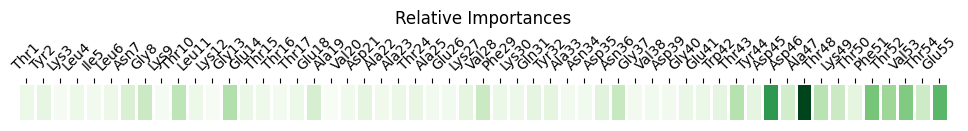

In [30]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims(ig_importances, axis=0), cbar=False, xticklabels=labels,
    yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Relative Importances")

## Map Importances to pseudo 3D structure


In [31]:
from alphafold.common import protein
from colabfold.colabfold import plot_pseudo_3D, protein_best_view

In [32]:
final_atom_mask = ig_results["structure_module"]["final_atom_mask"]
b_factors = ig_results["plddt"][:, None] * final_atom_mask
protein_obj = protein.from_prediction(
    features=single_iter_input_features,
    result=ig_results,
    b_factors=b_factors,
    remove_leading_feature_dimension=("multimer" not in model_type),
)

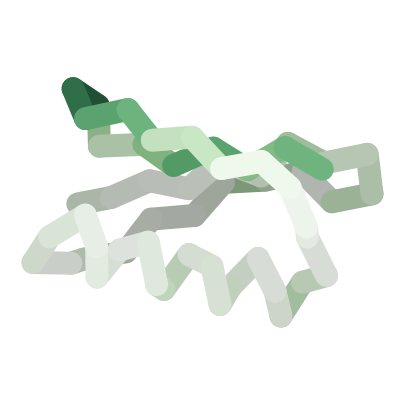

In [33]:
plot_pseudo_3D(
    protein_best_view(protein_obj.atom_positions[:, 1, :]),
    c=np.squeeze(ig_importances),
    cmap="Greens",
)

## Display 3D structure


- Taken directly from the [Colabfold Notebook](https://github.com/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb)


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

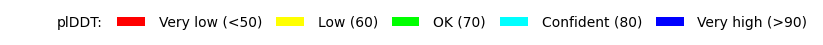

In [34]:
import glob

import py3Dmol
from colabfold.colabfold import (
    alphabet_list,
    pymol_color_list,
    plot_plddt_legend,
)

rank_num = 1  # possible values - ["1", "2", "3", "4", "5"]
color = "lDDT"  # possible values - ["chain", "lDDT", "rainbow"]
show_sidechains = False
show_mainchains = True

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)


def show_pdb(
    rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"
):
    model_name = f"rank_{rank_num}"
    view = py3Dmol.view(
        js="https://3dmol.org/build/3Dmol.js",
    )
    view.addModel(open(pdb_file[0], "r").read(), "pdb")

    if color == "lDDT":
        view.setStyle(
            {
                "cartoon": {
                    "colorscheme": {
                        "prop": "b",
                        "gradient": "roygb",
                        "min": 50,
                        "max": 90,
                    }
                }
            }
        )
    elif color == "rainbow":
        view.setStyle({"cartoon": {"color": "spectrum"}})
    elif color == "chain":
        chains = len(queries[0][1]) + 1 if is_complex else 1
        for n, chain, color in zip(
            range(chains), alphabet_list, pymol_color_list
        ):
            view.setStyle({"chain": chain}, {"cartoon": {"color": color}})

    if show_sidechains:
        BB = ["C", "O", "N"]
        view.addStyle(
            {
                "and": [
                    {"resn": ["GLY", "PRO"], "invert": True},
                    {"atom": BB, "invert": True},
                ]
            },
            {"stick": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )
        view.addStyle(
            {"and": [{"resn": "GLY"}, {"atom": "CA"}]},
            {"sphere": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )
        view.addStyle(
            {"and": [{"resn": "PRO"}, {"atom": ["C", "O"], "invert": True}]},
            {"stick": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )
    if show_mainchains:
        BB = ["C", "O", "N", "CA"]
        view.addStyle(
            {"atom": BB},
            {"stick": {"colorscheme": f"WhiteCarbon", "radius": 0.3}},
        )

    view.zoomTo()
    return view


show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
    plot_plddt_legend().show()

## Map importances to 3D structure


In [35]:
rank_num = 1  # possible values - ["1", "2", "3", "4", "5"]
color = "lDDT"  # possible values - ["chain", "lDDT", "rainbow"]
show_sidechains = False
show_mainchains = True

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

In [36]:
model_name = f"rank_{rank_num}"
view = py3Dmol.view(
    js="https://3dmol.org/build/3Dmol.js",
)
system = open(pdb_file[0], "r").read()
view.addModel(system, "pdb")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [37]:
c = np.squeeze(ig_importances)
c = (c - c.min()) / (c.max() - c.min())
colors = matplotlib.colormaps.get_cmap("Greens")(c)

In [38]:
xyz = protein_obj.atom_positions[:, 1, :]

In [39]:
xyz = np.asarray(xyz)
z = xyz[:, 2]
z = ((z - z.min()) / (z.max() - z.min()))[:, None]
tint, shade = z / 3, (z + 2) / 3
colors = colors + (1 - colors) * tint
colors = colors * shade

In [40]:
i = 0
for line in system.split("\n"):
    if not (line):
        continue
    entries = line.split()
    if entries[0] == "ATOM":
        color = matplotlib.colors.to_hex(colors[int(entries[5]) - 1, :])
        view.setStyle(
            {"model": -1, "serial": i + 1}, {"cartoon": {"color": color}}
        )
        i += 1

In [41]:
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# Correlate IG Importances to Evolutionary Conservation


In [42]:
ec_df = pd.read_csv(f'ConSurf/{protein_name}.txt', sep='\t', index_col=0)

if protein_name == 'B1':
    ec_df = ec_df.loc[228:282]  # only for B1 domain

ec_df.columns = ec_df.columns.str.strip()
ec_df = ec_df.applymap(lambda x: x.strip() if type(x) == str else x)
ec_importances = ec_df.COLOR.values.astype(int)
ec_importances = ec_importances/np.linalg.norm(ec_importances)

/tmp/ipykernel_32858/1109432658.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ec_df = ec_df.applymap(lambda x: x.strip() if type(x) == str else x)


## Cosine Similarity

- Pearson correlation coefficient is the cosine similarity between centered vectors (i.e. zero mean) - [Link](https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)


In [43]:
# mean normalize the vectors to get negative values in the vectors
dst_similarity_ig = (
    np.dot(ig_importances - ig_importances.mean(),
           ec_importances - ec_importances.mean())
) / (
    np.linalg.norm(ig_importances - ig_importances.mean()) *
    np.linalg.norm(ec_importances - ec_importances.mean())
)

In [44]:
print(f'DST Similarity: {dst_similarity_ig}')

DST Similarity: 0.23508394097693533


## Visualize Evolutionary Conservation


Text(0.5, 1.0, 'Evolutionary Conservation')

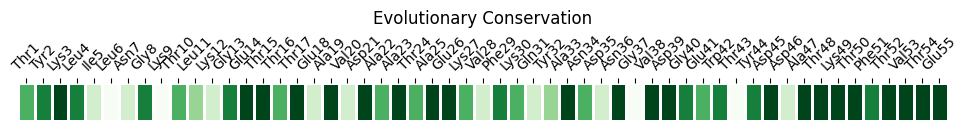

In [45]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims(ec_importances, axis=0), cbar=False, xticklabels=labels,
    yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Evolutionary Conservation")

## Visualize Functional Residues


Text(0.5, 1.0, 'Functional Residues')

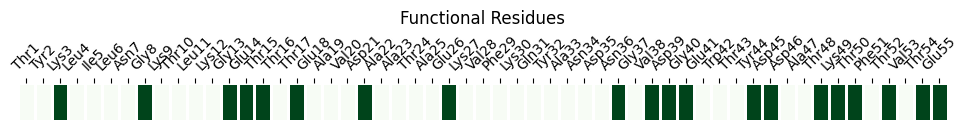

In [46]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims((ec_df.loc[:, "F/S"].values == 'f').astype(int), axis=0),
    cbar=False, xticklabels=labels, yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Functional Residues")

## Visualize Structural Residues


Text(0.5, 1.0, 'Structural Residues')

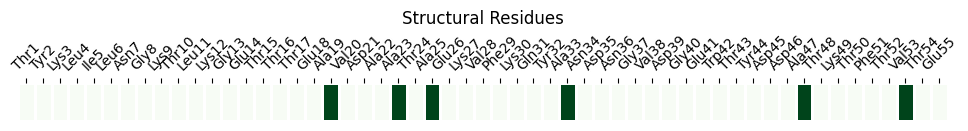

In [47]:
if protein_name == "Sso10a":
    plt.figure(figsize=(25, 0.5))
else:
    plt.figure(figsize=(12, 0.5))
ax = sns.heatmap(
    np.expand_dims((ec_df.loc[:, "F/S"].values == 's').astype(int), axis=0),
    cbar=False, xticklabels=labels, yticklabels=[], linewidths=2, cmap="Greens"
)
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
if protein_name == "Sso10a":
    ax.tick_params(axis='x', rotation=60)
else:
    ax.tick_params(axis='x', rotation=45)
ax.set_title("Structural Residues")

## Pearson Correlation Coefficient


In [48]:
pearson_corr = pearsonr(ec_importances, ig_importances)
print(f"Pearson Correlation Coefficient: {pearson_corr.statistic}")

Pearson Correlation Coefficient: 0.2350839448831073


## Spearman Correlation Coefficient


In [49]:
spearman_corr = spearmanr(ec_importances, ig_importances)
print(f"Spearman Correlation Coefficient: {spearman_corr.statistic}")

Spearman Correlation Coefficient: 0.14248443416729736


: 